### Annotate snATAC-seq clusters using gene imputation and RNA label transferring

ATAC-seq clusters are harder to annotate as the peaks do not necessary correspond to gene expression (even in the gene body or promoter regions). As we do NOT have multiome data here, we will use 2 approaches to annotate the leiden clusters identified in the harmonized data.

1. Gene imputed count matrix marker gene expressions using MAGIC imputation: we will just look for marker genes for each leiden cluster. Tried perform integration with snRNA-seq + snATAC-seq but this did not work well (ATAC and RNA formed separate clusters) as the imputed counts (ATAC) and log transformed counts for RNA did not seem to be on the same scale.  
2. 10X Multiome label transfer of the scRNA-seq labels onto the snATAC-seq modality: use the subset of multiome samples to identify which snRNA-seq annotation is most consistent with each cluster in

In [1]:
import scanpy as sc 
import pandas as pd
import numpy as np
import snapatac2 as snap
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from collections import Counter

In [2]:
def reverse_complement(sequence):
    """Return the reverse complement of a DNA sequence.
    This is needed in order to get the ATAC barcodes to match up with the RNA barcodes."""
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    # Get the reverse complement
    return ''.join(complement[base] for base in reversed(sequence))

Load in the ATAC gene imputed matrix (does not store the tile matrix), but once we perform cell type annotation, we will transfer over the annotations

In [3]:
%%time
# load in the gene imputed matrix -- this will take quite a while as it is very large
adata = sc.read_h5ad("gene_matrix_MAGIC_imputed.h5ad")
adata

CPU times: user 12 s, sys: 8min 45s, total: 8min 57s
Wall time: 12min 32s


AnnData object with n_obs × n_vars = 756726 × 59215
    obs: 'barcode', 'sample_id', 'leiden', 'donor_id', 'study', 'age_status', 'age', 'sex', 'region', 'disease_binary', 'technology', 'fragment_file', 'full_path', 'file', 'nfrag', 'tsse'
    var: 'n_cells'
    uns: 'log1p', 'rank_genes_groups'
    obsm: 'X_umap'
    layers: 'raw_counts'

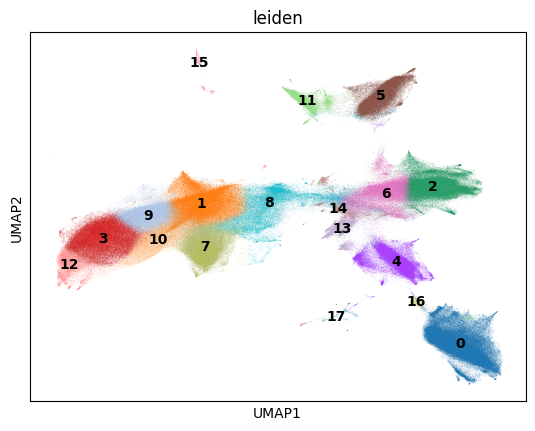

In [4]:
sc.pl.umap(adata, color = "leiden", legend_loc = "on data")

In [5]:
adata_metadata = adata.obs

#### Examine number of cell types 

/mnt/data1/william/tmp/ipykernel_3425514/3479630252.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_per_cell_type_disease_status = adata_metadata.groupby(["disease_binary", "age_status"]).count()['barcode'].reset_index()


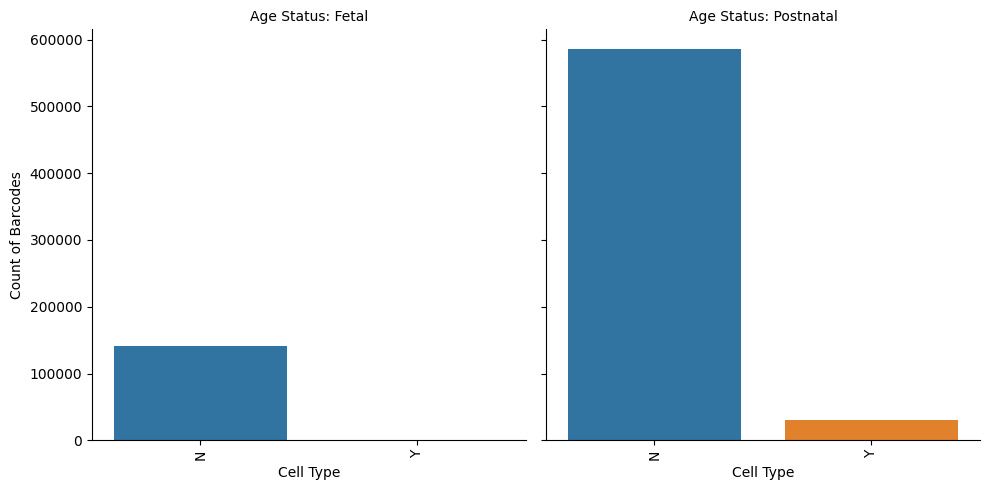

In [6]:
counts_per_cell_type_disease_status = adata_metadata.groupby(["disease_binary", "age_status"]).count()['barcode'].reset_index()
g = sns.catplot(data = counts_per_cell_type_disease_status, x = 'disease_binary', y = 'barcode', 
            hue = 'disease_binary', col='age_status', kind='bar')

g.set_axis_labels("Cell Type", "Count of Barcodes")
g.set_titles("Age Status: {col_name}")

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        
plt.tight_layout()

plt.show()

### Approach 1: Annotate leiden clusters based on top enriched genes per cluster

In [7]:
top_genes_per_cluster_list = list()
leiden_clusters = adata_metadata.leiden.unique()
for leiden_cluster in leiden_clusters:
    top_genes = sc.get.rank_genes_groups_df(adata, group=leiden_cluster).head(20)['names'].reset_index()
    top_genes['leiden'] = leiden_cluster
    top_genes_per_cluster_list.append(top_genes)

In [8]:
top_genes_per_cluster_df = pd.concat(top_genes_per_cluster_list)
top_genes_per_cluster_df = top_genes_per_cluster_df.drop(columns = "index")
top_genes_per_cluster_df['leiden'] = top_genes_per_cluster_df['leiden'].astype(int)
top_genes_per_cluster_df = top_genes_per_cluster_df.pivot(columns = "leiden", values = "names")

In [9]:
top_genes_per_cluster_df.iloc[:, 0:10]

leiden,0,1,2,3,4,5,6,7,8,9
0,VWF,RYR2,GAS7,RYR2,BCAS3,RBM47,KAZN,MTUS2,CSMD1,RYR2
1,MCF2L,FHOD3,RORA,MYOM2,ANO1,MS4A4A,GAS7,TSPAN9,RBFOX1,TTN
2,FLT1,TTN,GLIS3,TTN,SPRY4-AS1,CSF1R,BNC2,RBM20,CNTNAP2,TTN-AS1
3,MECOM,LDB3,EGFR,TTN-AS1,PDGFRB,LY86-AS1,ENSG00000282278,FHOD3,LRP1B,MYOM2
4,SHANK3,RBM20,BNC2,MYOM3,CACNA1H,DAPK1,GLIS3,SLC8A1,NRXN3,LDB3
5,PECAM1,TTN-AS1,BICC1,LDB3,EGFLAM,MBP,RORA,CASZ1,ROBO2,ENSG00000289258
6,LDB2,SORBS2,ENSG00000282278,ENSG00000289258,DAAM2,PIK3R5,BICC1,PLEKHA7,EYS,OBSCN
7,KIAA1671,ENSG00000289258,COL5A1,OBSCN,ZFHX3,RUNX1,COL5A1,KIF26B,MACROD2,FHOD3
8,SEC14L1,ADCY5,FBN1,MYLK3,EBF1,CDH23,FBN1,KCNH2,PTPRD,RBM20
9,ADGRF5,Y_RNA,FBLN5,ACOT11,FRMD3,ENSG00000284999,ADAMTS2,SORBS2,DLG2,FHL2


In [10]:
top_genes_per_cluster_df.iloc[:, 10:27]

leiden,10,11,12,13,14,15,16,17
0,RYR2,IKZF1,RYR2,EBF2,NRXN3,TMPRSS2,EBF1,CNTNAP2
1,TTN,RUNX3,MYOM2,GLI2,NRXN1,KRT8,CBFA2T3,CSMD1
2,TTN-AS1,SEMA4D,MYOM3,TARID,KLHL29,EPB41L4B,MGLL,NRXN3
3,OBSCN,TSPOAP1-AS1,ENSG00000274265,GPC6,NTM,CDH1,VWF,RBFOX1
4,LDB3,CCDC88C,ENSG00000223804,ADAMTS2,TRABD2B,LINC02532,FLT1,LRP1B
5,FHOD3,LINC01934,ENSG00000215861,MAML2,LNC-LBCS,PACSIN2,SPRY4-AS1,PTPRD
6,MYOM2,LINC01588,IP6K3,PKNOX2,PRICKLE2,TMEM51,ANO1,TENM1
7,MYO18B,AKNA,NRAP,RAD51B,XKR4,RBM47,ENSG00000278791,ENSG00000288098
8,ENSG00000289258,BCL11B,TTN,ENSG00000285090,MEGF6,LINC01237,EXD3,PCDH11X
9,SORBS2,RUNX1,PDE4DIP,CASC15,PKNOX2,ENSG00000285959,MTCO3P12,GPC5


### Add marker-gene imputation annotation

In [11]:
RNA_imputed_annotation_key = "RNA_gene_imputed_cell_type"

adata.obs[RNA_imputed_annotation_key] = adata.obs['leiden'].map(
    {
        "0": "Endothelial",
        "1": "Cardiomyocyte",
        "2": "Fibroblast",
        "3": "Cardiomyocyte",
        "4": "Pericyte",
        "5": "Myeloid",
        "6": "Fibroblast",
        "7": "Cardiomyocyte",
        "8": "Unclear",
        "9": "Cardiomyocyte",
        "10": "Cardiomyocyte",
        "11": "Lymphoid",
        "12": "Cardiomyocyte", 
        "13": "Unclear",
        "14": "Neuronal",
        "15": "Unclear",
        "16": "Unclear",
        "17": "Unclear",
    }
)

... storing 'RNA_gene_imputed_cell_type' as categorical


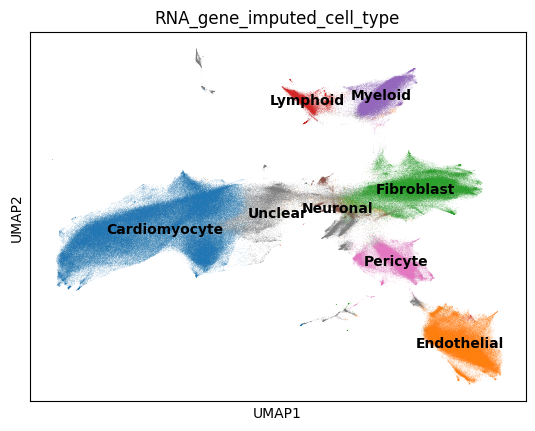

In [12]:
sc.pl.umap(adata, color = RNA_imputed_annotation_key, legend_loc = "on data")

#### Examine number of nuclei per leiden cluster

In [13]:
counts_per_leiden_cluster = adata_metadata.groupby(['leiden'])['barcode'].count().reset_index()

/mnt/data1/william/tmp/ipykernel_3425514/2810006032.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_per_leiden_cluster = adata_metadata.groupby(['leiden'])['barcode'].count().reset_index()


2025-01-03 19:03:26 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-03 19:03:26 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='leiden', ylabel='barcode'>

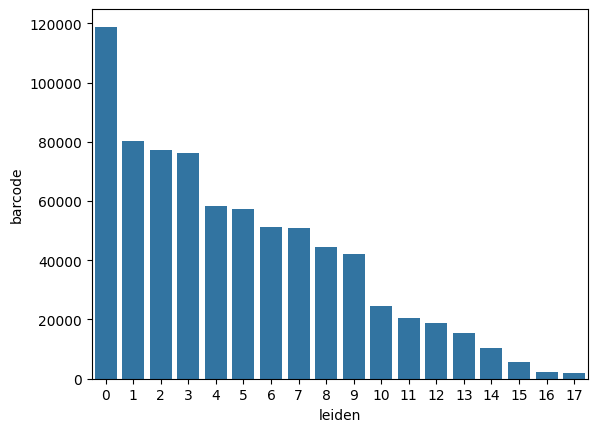

In [14]:
sns.barplot(data = counts_per_leiden_cluster, x = 'leiden', y = 'barcode')

In [15]:
counts_per_leiden_cluster

,leiden,barcode
0,0,118863
1,1,80173
2,2,77155
3,3,76370
4,4,58434
5,5,57271
6,6,51398
7,7,50876
8,8,44642
9,9,42168


### Approach 2: Label transfer for multiome data 

For ENCODE multiome data, transfer over the cell type annotation from RNA-seq

In [16]:
# barcode mapping for RNA and ATAC
multiome_barcode_df = pd.read_csv("multiome_mapping_files/ATAC_RNA_737K_barcodes.txt", index_col = 0)
multiome_barcode_df.head()

#ENCODE_pairing_df = pd.read_csv("multiome_mapping_files/ENCODE_ATAC_RNA_mapping.txt", delim_whitespace=True)
#ENCODE_pairing_df.head()

,RNA_barcode,ATAC_barcode
0,AAACAGCCAAACAACA,ACAGCGGGTGTGTTAC
1,AAACAGCCAAACATAG,ACAGCGGGTTGTTCTT
2,AAACAGCCAAACCCTA,ACAGCGGGTAACAGGC
3,AAACAGCCAAACCTAT,ACAGCGGGTGCGCGAA
4,AAACAGCCAAACCTTG,ACAGCGGGTCCTCCAT


In [17]:
ATAC_metadata = adata.obs
ATAC_metadata['ATAC_barcode'] = ATAC_metadata['barcode'].str.split(":").str[1]

In [19]:
%%time
# load in the entire RNA adata
RNA_adata = sc.read_h5ad("../../RNA/aggregated_analysis/07_final_RNA_without_scvi.h5ad")
RNA_adata

CPU times: user 22.9 s, sys: 2min 30s, total: 2min 53s
Wall time: 5min 26s


AnnData object with n_obs × n_vars = 2305964 × 16115
    obs: 'age', 'donor_id', 'sex', 'region', 'cell_type', 'disease', 'consistent_cell_type', 'study', 'technology', 'cell_or_nuclei', 'barcode', 'sample_id', 'age_status', 'tech_plus_study', 'disease_binary', 'decade', 'age_group', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'scvi_cell_type', 'redo_leiden_0.5', 'UMAP1', 'UMAP2', 'v2_scvi_cell_type', 'final_cell_type'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'counts'

In [20]:
# store the relevant columns, which includes final cell type annotation
RNA_adata_metadata = RNA_adata.obs[["final_cell_type", "donor_id", "sex", "age", "technology"]]
# isolate the RNA barcode
RNA_adata_metadata = RNA_adata_metadata.reset_index().rename(columns = {'index': 'full_barcode'})
RNA_adata_metadata['RNA_barcode'] = RNA_adata_metadata['full_barcode'].str.split(":", n=1).str[1].str.split("-", n=1).str[0]

In [21]:
# free space by removing the whole adata object (as we only need the metadata)
del RNA_adata
gc.collect()

32

### Filter to only the multiome data

In [23]:
multiome_ATAC_metadata = ATAC_metadata[ATAC_metadata['technology'] == "10X_Multiome"]
multiome_ATAC_metadata.shape

(532531, 18)

In [24]:
multiome_ATAC_metadata

,barcode,sample_id,leiden,donor_id,study,age_status,age,sex,region,disease_binary,technology,fragment_file,full_path,file,nfrag,tsse,RNA_gene_imputed_cell_type,ATAC_barcode
0,ENCSR495SMB:AAACATGCTCCCTCAC,ENCSR495SMB,0,ENCODE v4 (Snyder):ENCSR455MGH,ENCODE v4 (Snyder),Postnatal,32.0,female,LV,N,10X_Multiome,ENCSR495SMB_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,ENCSR495SMB_pre_trimmed_tsse_v_nfrags.png,2000,5,Endothelial,AAACATGCTCCCTCAC
1,ENCSR495SMB:AAACATGCTTCGCTTT,ENCSR495SMB,6,ENCODE v4 (Snyder):ENCSR455MGH,ENCODE v4 (Snyder),Postnatal,32.0,female,LV,N,10X_Multiome,ENCSR495SMB_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,ENCSR495SMB_pre_trimmed_tsse_v_nfrags.png,2000,5,Fibroblast,AAACATGCTTCGCTTT
2,ENCSR495SMB:AAACCATGACACCTAC,ENCSR495SMB,2,ENCODE v4 (Snyder):ENCSR455MGH,ENCODE v4 (Snyder),Postnatal,32.0,female,LV,N,10X_Multiome,ENCSR495SMB_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,ENCSR495SMB_pre_trimmed_tsse_v_nfrags.png,2000,5,Fibroblast,AAACCATGACACCTAC
3,ENCSR495SMB:AAACCATGACCGTTGT,ENCSR495SMB,6,ENCODE v4 (Snyder):ENCSR455MGH,ENCODE v4 (Snyder),Postnatal,32.0,female,LV,N,10X_Multiome,ENCSR495SMB_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,ENCSR495SMB_pre_trimmed_tsse_v_nfrags.png,2000,5,Fibroblast,AAACCATGACCGTTGT
4,ENCSR495SMB:AAACCATGAGCGCTAA,ENCSR495SMB,0,ENCODE v4 (Snyder):ENCSR455MGH,ENCODE v4 (Snyder),Postnatal,32.0,female,LV,N,10X_Multiome,ENCSR495SMB_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,ENCSR495SMB_pre_trimmed_tsse_v_nfrags.png,2000,5,Endothelial,AAACCATGAGCGCTAA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751406,ENCFF851VTB:TTTGTGGTGTTGCTCC,ENCFF851VTB,13,ENCODE v4 (Snyder):ENCFF775ANN,ENCODE v4 (Snyder),Fetal,15.0,female,WH,N,10X_Multiome,ENCFF851VTB_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,ENCFF851VTB_pre_trimmed_tsse_v_nfrags.png,2000,5,Unclear,TTTGTGGTGTTGCTCC
751407,ENCFF851VTB:TTTGTGTGATAACGAC,ENCFF851VTB,7,ENCODE v4 (Snyder):ENCFF775ANN,ENCODE v4 (Snyder),Fetal,15.0,female,WH,N,10X_Multiome,ENCFF851VTB_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,ENCFF851VTB_pre_trimmed_tsse_v_nfrags.png,2000,5,Cardiomyocyte,TTTGTGTGATAACGAC
751408,ENCFF851VTB:TTTGTGTGATCAGGTA,ENCFF851VTB,7,ENCODE v4 (Snyder):ENCFF775ANN,ENCODE v4 (Snyder),Fetal,15.0,female,WH,N,10X_Multiome,ENCFF851VTB_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,ENCFF851VTB_pre_trimmed_tsse_v_nfrags.png,2000,5,Cardiomyocyte,TTTGTGTGATCAGGTA
751409,ENCFF851VTB:TTTGTGTGATGTTGCC,ENCFF851VTB,1,ENCODE v4 (Snyder):ENCFF775ANN,ENCODE v4 (Snyder),Fetal,15.0,female,WH,N,10X_Multiome,ENCFF851VTB_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,ENCFF851VTB_pre_trimmed_tsse_v_nfrags.png,2000,5,Cardiomyocyte,TTTGTGTGATGTTGCC


#### Kanemaru multiome uses the RNA barcodes, so need to use these for mapping

In [25]:
Kanemaru_multiome_metadata = multiome_ATAC_metadata[multiome_ATAC_metadata['study'] == "Kanemaru 2023"].copy()
Kanemaru_multiome_metadata['ATAC_barcode'] = Kanemaru_multiome_metadata['ATAC_barcode'].str.split("-", n=1).str[0]
Kanemaru_multiome_metadata['RNA_barcode'] = Kanemaru_multiome_metadata['ATAC_barcode']

Kanemaru_multiome_metadata = Kanemaru_multiome_metadata.merge(multiome_barcode_df, on = "RNA_barcode")

Kanemaru_multiome_metadata = Kanemaru_multiome_metadata.drop(columns = "ATAC_barcode_y")
Kanemaru_multiome_metadata = Kanemaru_multiome_metadata.rename(columns = {"ATAC_barcode_x" : "ATAC_barcode"})

print(Kanemaru_multiome_metadata.shape)

(31215, 19)


In [26]:
ENCODE_multiome_metadata = multiome_ATAC_metadata[multiome_ATAC_metadata['study'] == "ENCODE v4 (Snyder)"].copy()
ENCODE_multiome_metadata['ATAC_barcode'] = ENCODE_multiome_metadata['ATAC_barcode'].apply(lambda x: reverse_complement(x))
ENCODE_multiome_metadata = ENCODE_multiome_metadata.merge(multiome_barcode_df, on = "ATAC_barcode")

print(ENCODE_multiome_metadata.shape)

(501316, 19)


In [27]:
combined_multiome_metadata = pd.concat([Kanemaru_multiome_metadata, ENCODE_multiome_metadata])
combined_multiome_metadata.shape

(532531, 19)

#### Examine RNA metadata for multiome only

In [28]:
multiome_donors = ATAC_metadata[ATAC_metadata['technology'] == "10X_Multiome"].donor_id.unique()
print(f"Multiome donors in ATAC: {len(multiome_donors)}")
multiome_donors_in_RNA = len(RNA_adata_metadata[RNA_adata_metadata['donor_id'].isin(multiome_donors)].donor_id.unique())
print(f"Multiome donors from ATAC in RNA: {multiome_donors_in_RNA}")

Multiome donors in ATAC: 67
Multiome donors from ATAC in RNA: 66


In [29]:
# filter RNA metadata to multiome
multiome_RNA_metadata = RNA_adata_metadata[RNA_adata_metadata['donor_id'].isin(multiome_donors)]
print(multiome_RNA_metadata.shape)

# merge on the RNA-ATAC barcode
multiome_RNA_metadata = multiome_RNA_metadata.merge(multiome_barcode_df, on = "RNA_barcode")

# filter to necessary metadata
multiome_RNA_metadata = multiome_RNA_metadata[["RNA_barcode", "final_cell_type", "donor_id"]]

(510638, 7)


#### Join the information together

In [30]:
merged_multiome_df = combined_multiome_metadata.merge(multiome_RNA_metadata, on = ["RNA_barcode", "donor_id"])
merged_multiome_df.index = merged_multiome_df.barcode
merged_multiome_df.head()

,barcode,sample_id,leiden,donor_id,study,age_status,age,sex,region,disease_binary,technology,fragment_file,full_path,file,nfrag,tsse,RNA_gene_imputed_cell_type,ATAC_barcode,RNA_barcode,final_cell_type
barcode,,,,,,,,,,,,,,,,,,,,
HCAHeart9508627_HCAHeart9508819:AAACATGCAGCAGGTA-1,HCAHeart9508627_HCAHeart9508819:AAACATGCAGCAGG...,HCAHeart9508627_HCAHeart9508819,4,Kanemaru 2023:D3-Nuclei_Multiome-v1,Kanemaru 2023,Postnatal,57.5,male,LV,N,10X_Multiome,HCAHeart9508627_HCAHeart9508819_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,HCAHeart9508627_HCAHeart9508819_pre_trimmed_ts...,2000,5,Pericyte,AAACATGCAGCAGGTA,AAACATGCAGCAGGTA,Pericyte
HCAHeart9508627_HCAHeart9508819:AAACATGCATAGCTGC-1,HCAHeart9508627_HCAHeart9508819:AAACATGCATAGCT...,HCAHeart9508627_HCAHeart9508819,3,Kanemaru 2023:D3-Nuclei_Multiome-v1,Kanemaru 2023,Postnatal,57.5,male,LV,N,10X_Multiome,HCAHeart9508627_HCAHeart9508819_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,HCAHeart9508627_HCAHeart9508819_pre_trimmed_ts...,2000,5,Cardiomyocyte,AAACATGCATAGCTGC,AAACATGCATAGCTGC,Cardiomyocyte
HCAHeart9508627_HCAHeart9508819:AAACCAACAAGGTGCA-1,HCAHeart9508627_HCAHeart9508819:AAACCAACAAGGTG...,HCAHeart9508627_HCAHeart9508819,5,Kanemaru 2023:D3-Nuclei_Multiome-v1,Kanemaru 2023,Postnatal,57.5,male,LV,N,10X_Multiome,HCAHeart9508627_HCAHeart9508819_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,HCAHeart9508627_HCAHeart9508819_pre_trimmed_ts...,2000,5,Myeloid,AAACCAACAAGGTGCA,AAACCAACAAGGTGCA,Myeloid
HCAHeart9508627_HCAHeart9508819:AAACCAACACTTAACG-1,HCAHeart9508627_HCAHeart9508819:AAACCAACACTTAA...,HCAHeart9508627_HCAHeart9508819,3,Kanemaru 2023:D3-Nuclei_Multiome-v1,Kanemaru 2023,Postnatal,57.5,male,LV,N,10X_Multiome,HCAHeart9508627_HCAHeart9508819_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,HCAHeart9508627_HCAHeart9508819_pre_trimmed_ts...,2000,5,Cardiomyocyte,AAACCAACACTTAACG,AAACCAACACTTAACG,Cardiomyocyte
HCAHeart9508627_HCAHeart9508819:AAACCAACAGCCGCTA-1,HCAHeart9508627_HCAHeart9508819:AAACCAACAGCCGC...,HCAHeart9508627_HCAHeart9508819,9,Kanemaru 2023:D3-Nuclei_Multiome-v1,Kanemaru 2023,Postnatal,57.5,male,LV,N,10X_Multiome,HCAHeart9508627_HCAHeart9508819_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,HCAHeart9508627_HCAHeart9508819_pre_trimmed_ts...,2000,5,Cardiomyocyte,AAACCAACAGCCGCTA,AAACCAACAGCCGCTA,Cardiomyocyte


In [31]:
adata_metadata.index = adata_metadata.barcode

In [32]:
new_adata_metadata = adata_metadata.loc[merged_multiome_df.index, :]

In [33]:
new_adata_metadata['final_cell_type'] = merged_multiome_df.final_cell_type

### Look at the correlation between the RNA gene imputed cell type and the label transferred cell type

In [34]:
cell_type_consistency = pd.crosstab(new_adata_metadata['final_cell_type'], new_adata_metadata['RNA_gene_imputed_cell_type'])
# row-normalize and multiple by 100 to get percentages
norm_cell_type_consistency =  cell_type_consistency.div(cell_type_consistency.sum(axis = 1), axis = 0)

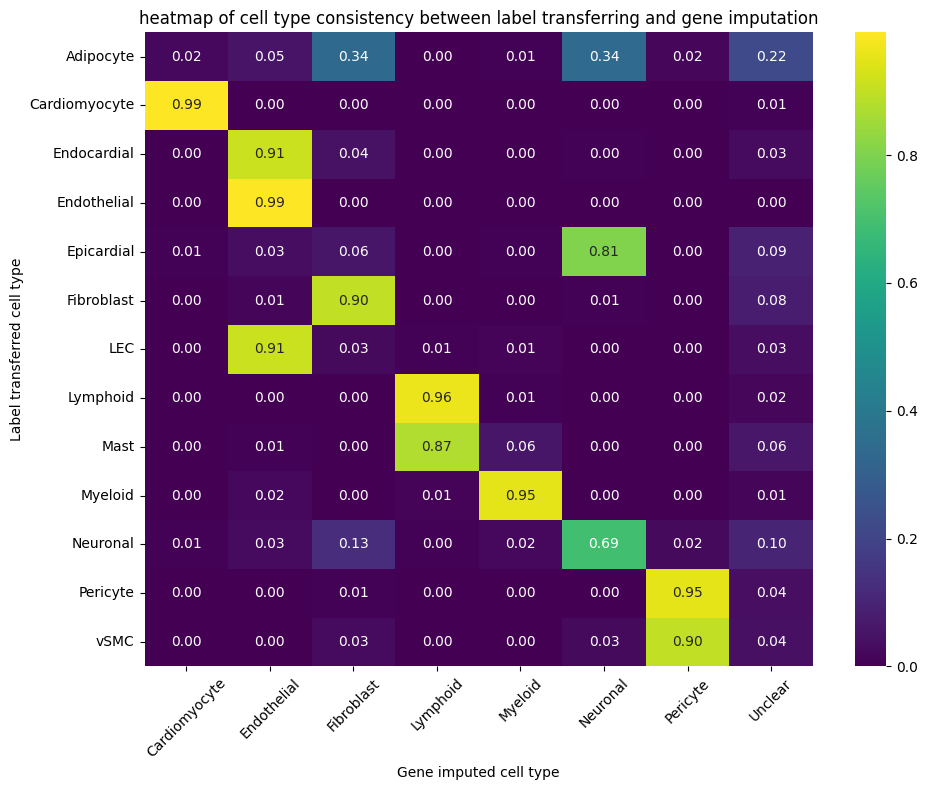

In [35]:
plt.figure(figsize=(10, 8))
sns.heatmap(norm_cell_type_consistency, cmap='viridis', annot=True, fmt='.2f', cbar=True)
plt.title('heatmap of cell type consistency between label transferring and gene imputation')
plt.ylabel('Label transferred cell type')
plt.xlabel('Gene imputed cell type')
plt.xticks(rotation=45)  
plt.yticks(rotation=0)    
plt.tight_layout()        
plt.show()        

### Now, look at what leiden clusters corresponding to in terms of RNA cell types

In [36]:
# now, examine which cell type annotations are most represented in each ATAC leiden cluster 
cell_type_annotations_per_leiden = pd.crosstab(merged_multiome_df['leiden'], merged_multiome_df['final_cell_type'])

# row-normalize and multiple by 100 to get percentages
norm_cell_type_annotations_per_leiden =  cell_type_annotations_per_leiden.div(cell_type_annotations_per_leiden.sum(axis = 1), axis = 0)

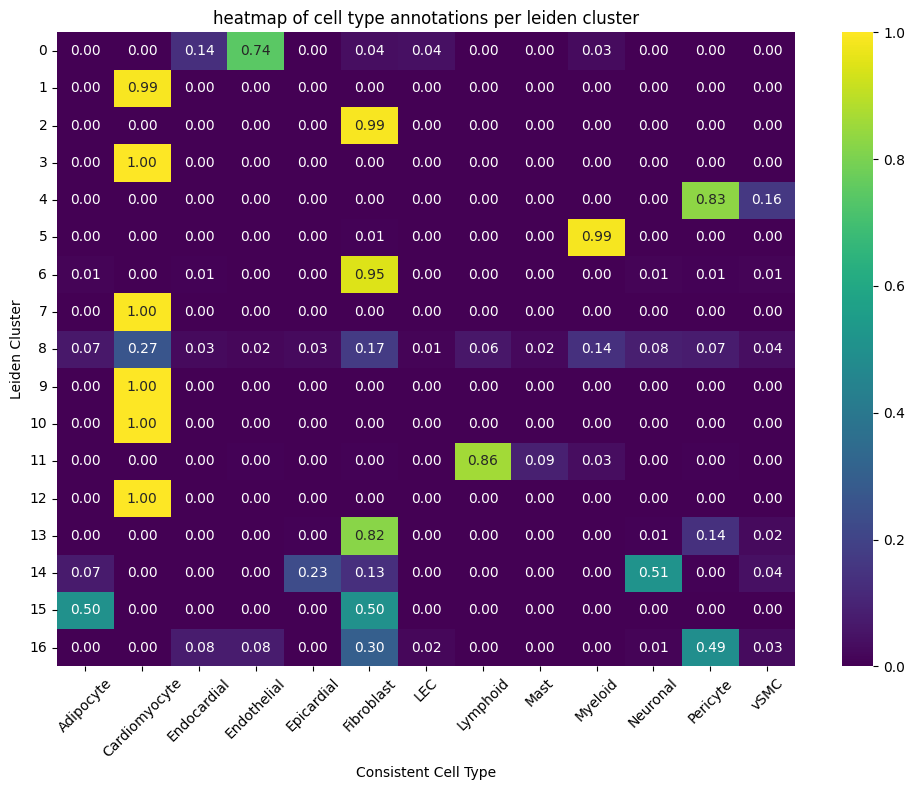

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(norm_cell_type_annotations_per_leiden, cmap='viridis', annot=True, fmt='.2f', cbar=True)
plt.title('heatmap of cell type annotations per leiden cluster')
plt.xlabel('Consistent Cell Type')
plt.ylabel('Leiden Cluster')
plt.xticks(rotation=45)  
plt.yticks(rotation=0)    
plt.tight_layout()        
plt.show()              

Now, for clusters with >90% identity in one cell type, we will provide that label transfer annotation to the adata. For those that are split between two cell types that are >90% when summed together, we will describe them as "Cell type A / cell type B"

In [38]:
RNA_label_transfer_annotation_key = "RNA_label_transfer_cell_type"

adata.obs[RNA_label_transfer_annotation_key] = adata.obs['leiden'].map(
    {
        "0": "Endothelial",
        "1": "Cardiomyocyte",
        "2": "Fibroblast",
        "3": "Cardiomyocyte",
        "4": "Pericyte-vSMC",
        "5": "Myeloid",
        "6": "Fibroblast",
        "7": "Cardiomyocyte",
        "8": "Mixed",
        "9": "Cardiomyocyte",
        "10": "Cardiomyocyte",
        "11": "Lymphoid-Mast",
        "12": "Cardiomyocyte", 
        "13": "Fibroblast",
        "14": "Neuronal-Epicardial",
        "15": "Adipocyte",
        "16": "Mixed",
        "17": "Mixed",
    }
)

In [39]:
# save the updated metadata
updated_adata_metadata = adata.obs
updated_adata_metadata.head()

,barcode,sample_id,leiden,donor_id,study,age_status,age,sex,region,disease_binary,technology,fragment_file,full_path,file,nfrag,tsse,RNA_gene_imputed_cell_type,ATAC_barcode,RNA_label_transfer_cell_type
barcode,,,,,,,,,,,,,,,,,,,
ENCSR495SMB:AAACATGCTCCCTCAC,ENCSR495SMB:AAACATGCTCCCTCAC,ENCSR495SMB,0,ENCODE v4 (Snyder):ENCSR455MGH,ENCODE v4 (Snyder),Postnatal,32.0,female,LV,N,10X_Multiome,ENCSR495SMB_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,ENCSR495SMB_pre_trimmed_tsse_v_nfrags.png,2000,5,Endothelial,AAACATGCTCCCTCAC,Endothelial
ENCSR495SMB:AAACATGCTTCGCTTT,ENCSR495SMB:AAACATGCTTCGCTTT,ENCSR495SMB,6,ENCODE v4 (Snyder):ENCSR455MGH,ENCODE v4 (Snyder),Postnatal,32.0,female,LV,N,10X_Multiome,ENCSR495SMB_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,ENCSR495SMB_pre_trimmed_tsse_v_nfrags.png,2000,5,Fibroblast,AAACATGCTTCGCTTT,Fibroblast
ENCSR495SMB:AAACCATGACACCTAC,ENCSR495SMB:AAACCATGACACCTAC,ENCSR495SMB,2,ENCODE v4 (Snyder):ENCSR455MGH,ENCODE v4 (Snyder),Postnatal,32.0,female,LV,N,10X_Multiome,ENCSR495SMB_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,ENCSR495SMB_pre_trimmed_tsse_v_nfrags.png,2000,5,Fibroblast,AAACCATGACACCTAC,Fibroblast
ENCSR495SMB:AAACCATGACCGTTGT,ENCSR495SMB:AAACCATGACCGTTGT,ENCSR495SMB,6,ENCODE v4 (Snyder):ENCSR455MGH,ENCODE v4 (Snyder),Postnatal,32.0,female,LV,N,10X_Multiome,ENCSR495SMB_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,ENCSR495SMB_pre_trimmed_tsse_v_nfrags.png,2000,5,Fibroblast,AAACCATGACCGTTGT,Fibroblast
ENCSR495SMB:AAACCATGAGCGCTAA,ENCSR495SMB:AAACCATGAGCGCTAA,ENCSR495SMB,0,ENCODE v4 (Snyder):ENCSR455MGH,ENCODE v4 (Snyder),Postnatal,32.0,female,LV,N,10X_Multiome,ENCSR495SMB_fragments.tsv.gz,/mnt/data1/william/human_heart_project/Final_m...,ENCSR495SMB_pre_trimmed_tsse_v_nfrags.png,2000,5,Endothelial,AAACCATGAGCGCTAA,Endothelial


### Examine proportions of each leiden cluster by study

In [40]:
# proportions of cells overall in each study
n_cells_per_study = updated_adata_metadata.groupby("study").count()['age'].reset_index()
n_cells_per_study = n_cells_per_study.rename(columns = {"age": "n_cells"})
n_cells_per_study['prop'] = n_cells_per_study['n_cells'] / n_cells_per_study['n_cells'].sum()
n_cells_per_study

/mnt/data1/william/tmp/ipykernel_3425514/2662931607.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  n_cells_per_study = updated_adata_metadata.groupby("study").count()['age'].reset_index()


,study,n_cells,prop
0,Ameen 2022,17735,0.023436
1,ENCODE v4 (Snyder),540005,0.713607
2,Kanemaru 2023,31215,0.041250
3,Kuppe 2022,36934,0.048808
4,Penn,130837,0.172899


In [41]:
def produce_crosstab_barplot(metadata, cluster_label, metadata_column):
    '''Produce a barplot showing how the cluster_label (e.g. leiden) distributes according to a metadata column (e.g. study)'''

    prop_df = pd.crosstab(metadata[cluster_label], metadata[metadata_column])
    norm_prop_df = prop_df.div(prop_df.sum(axis = 1), axis = 0)

    ax = norm_prop_df.plot(kind = 'bar', stacked=True, figsize=(15, 5), colormap='tab20')
    ax.set_xlabel(cluster_label)
    ax.set_ylabel("Proportion")
    ax.set_title("Proportion per {cluster_label} grouped by {metadata_column}")

    # reverse the legend order so that it matches up with the barplot
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title={cluster_label}, bbox_to_anchor=(1.05, 1), loc='upper left')

    # rotate the x labels
    plt.xticks(rotation=90, ha='right')
    return plt

Produce plots based on leiden clusters

<module 'matplotlib.pyplot' from '/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/matplotlib/pyplot.py'>

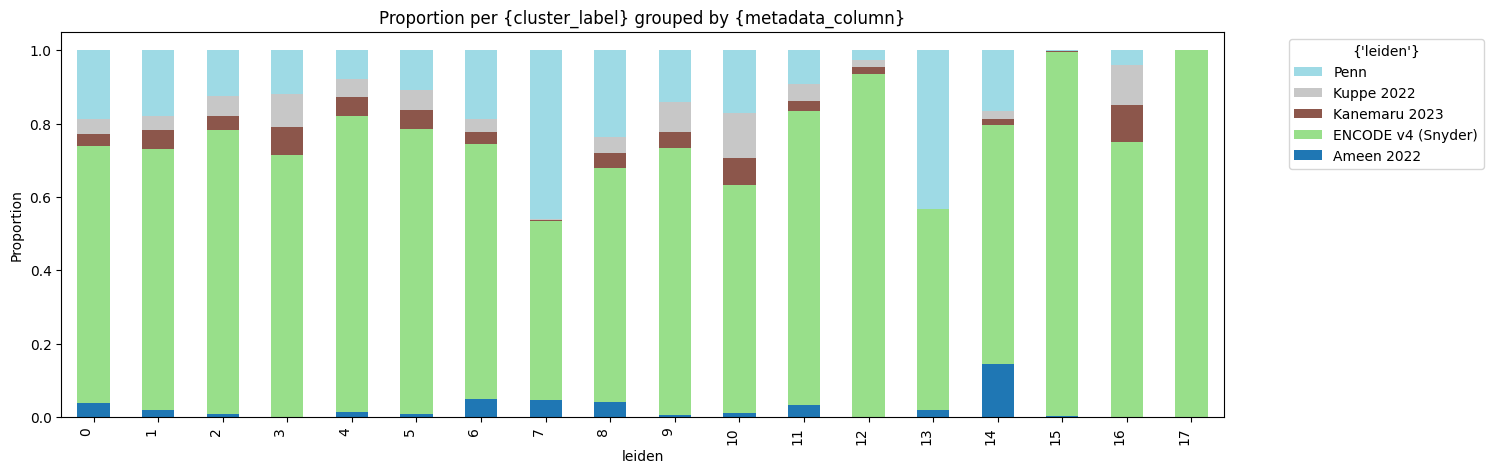

In [42]:
produce_crosstab_barplot(metadata = updated_adata_metadata, cluster_label = 'leiden', metadata_column = 'study')

<module 'matplotlib.pyplot' from '/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/matplotlib/pyplot.py'>

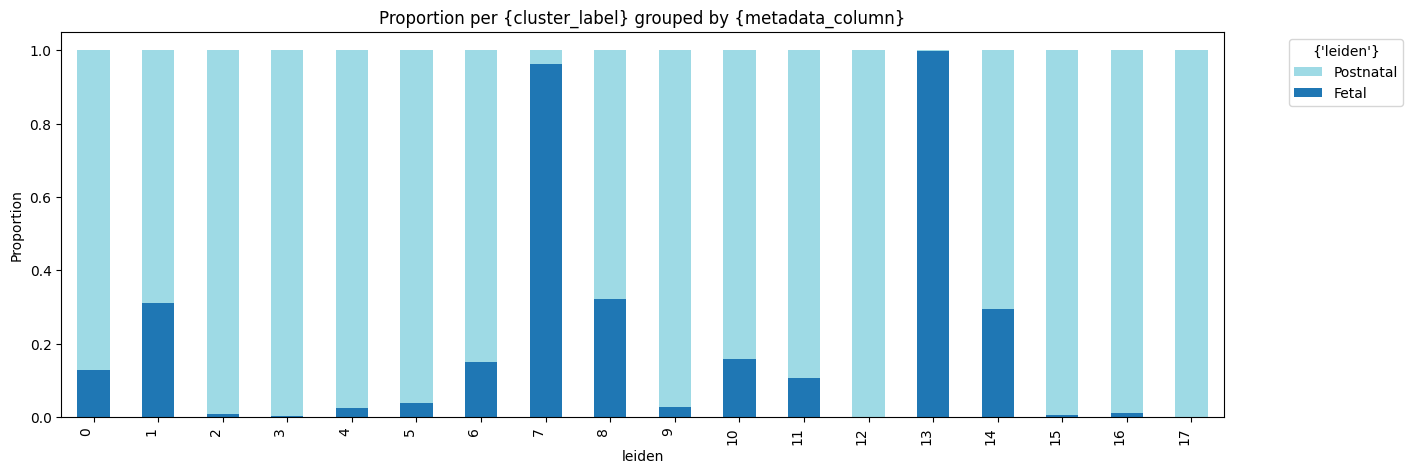

In [43]:
produce_crosstab_barplot(metadata = updated_adata_metadata, cluster_label = 'leiden', metadata_column = 'age_status')

<module 'matplotlib.pyplot' from '/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/matplotlib/pyplot.py'>

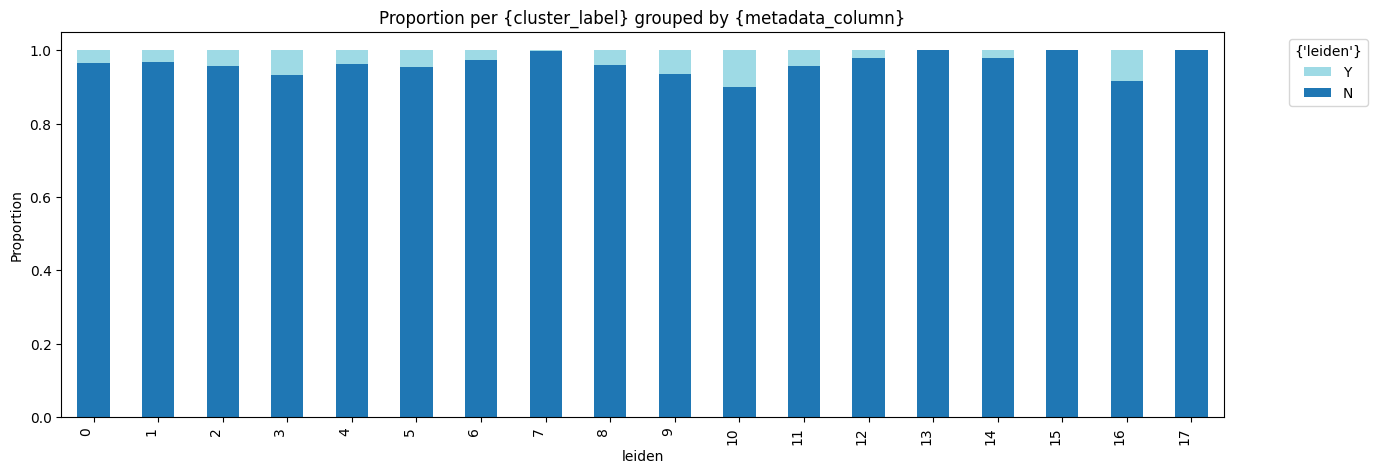

In [44]:
produce_crosstab_barplot(metadata = updated_adata_metadata, cluster_label = 'leiden', metadata_column = 'disease_binary')

Produce plots based on annotations predicted from label transferring

<module 'matplotlib.pyplot' from '/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/matplotlib/pyplot.py'>

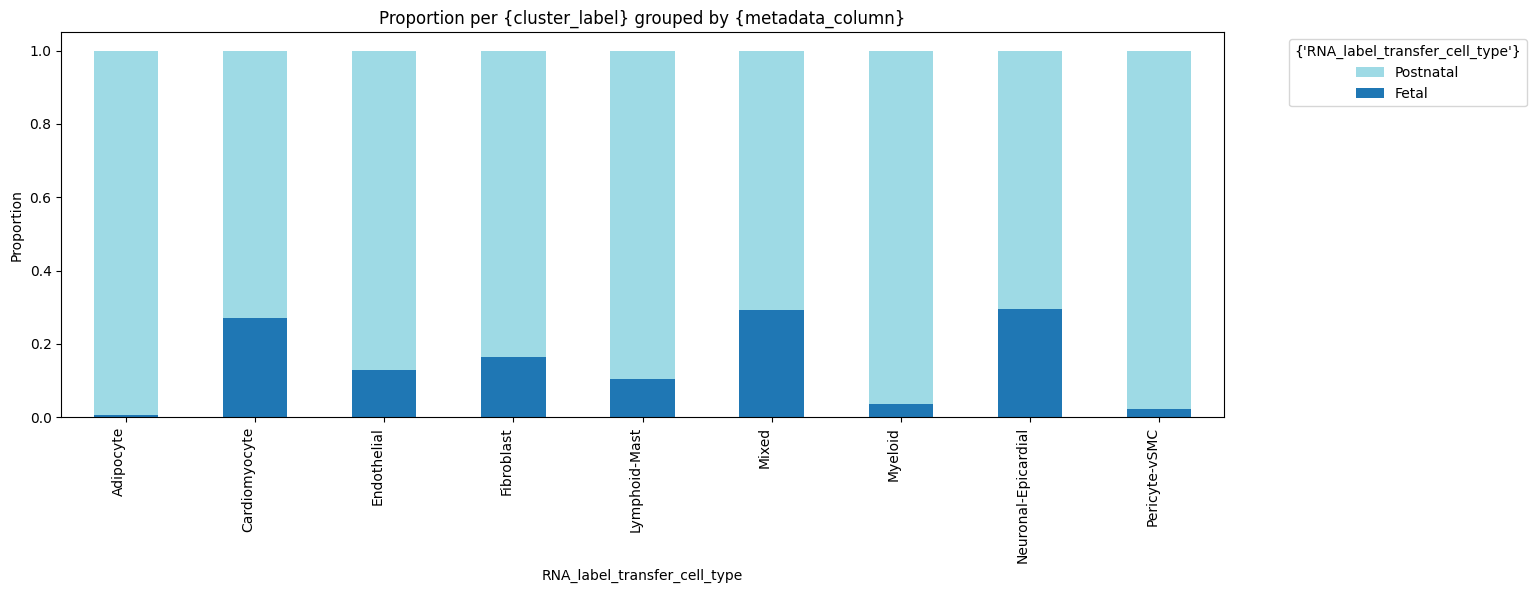

In [45]:
produce_crosstab_barplot(metadata = updated_adata_metadata, cluster_label = RNA_label_transfer_annotation_key, 
                         metadata_column = 'age_status')

In [46]:
print(updated_adata_metadata.shape)

(756726, 19)


In [47]:
updated_adata_metadata.to_csv("04B_label_transferred_metadata.csv")

### Now, transfer this back to the harmonized adata that has the peak counts using step 05